<a href="https://colab.research.google.com/github/sesmael/Real-Time-ML-/blob/main/homework1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

100%|██████████| 170M/170M [00:03<00:00, 43.9MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Epoch 1/20, Loss: 1.8013, Train Acc: 0.3580, Val Acc: 0.4393
Epoch 2/20, Loss: 1.6381, Train Acc: 0.4214, Val Acc: 0.4677
Epoch 3/20, Loss: 1.5715, Train Acc: 0.4493, Val Acc: 0.4782
Epoch 4/20, Loss: 1.5231, Train Acc: 0.4647, Val Acc: 0.4926
Epoch 5/20, Loss: 1.4821, Train Acc: 0.4777, Val Acc: 0.4989
Epoch 6/20, Loss: 1.4528, Train Acc: 0.4890, Val Acc: 0.5132
Epoch 7/20, Loss: 1.4217, Train Acc: 0.5004, Val Acc: 0.5144
Epoch 8/20, Loss: 1.3975, Train Acc: 0.5071, Val Acc: 0.5120
Epoch 9/20, Loss: 1.3740, Train Acc: 0.5154, Val Acc: 0.5165
Epoch 10/20, Loss: 1.3531, Train Acc: 0.5238, Val Acc: 0.5159
Epoch 11/20, Loss: 1.3272, Train Acc: 0.5305, Val Acc: 0.5277
Epoch 12/20, Loss: 1.3165, Train Acc: 0.5338, Val Acc: 0.5263
Epoch 13/20, Loss: 1.2920, Train Acc: 0.5436, Val Acc: 0.5338
Epoch 14/20, Loss: 1.2713, Train Acc: 0.5508, Val Acc: 0.5368
Epoch 15/20, Loss: 1.2628, Train Acc: 0.5561, Val Ac

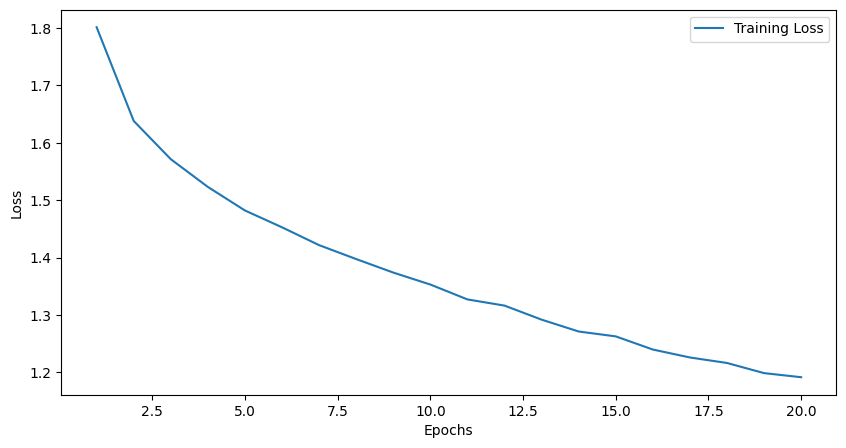

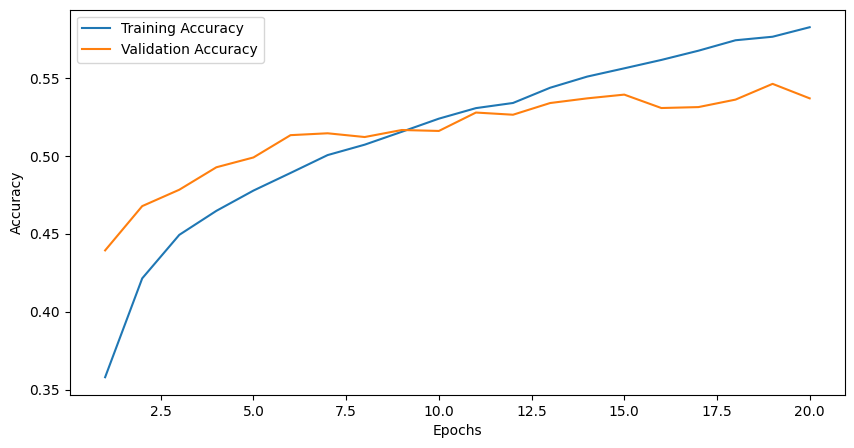

              precision    recall  f1-score   support

           0       0.54      0.68      0.61      1000
           1       0.68      0.65      0.67      1000
           2       0.42      0.42      0.42      1000
           3       0.33      0.49      0.40      1000
           4       0.45      0.45      0.45      1000
           5       0.54      0.24      0.34      1000
           6       0.57      0.64      0.60      1000
           7       0.70      0.58      0.63      1000
           8       0.63      0.64      0.64      1000
           9       0.65      0.57      0.61      1000

    accuracy                           0.54     10000
   macro avg       0.55      0.54      0.53     10000
weighted avg       0.55      0.54      0.53     10000



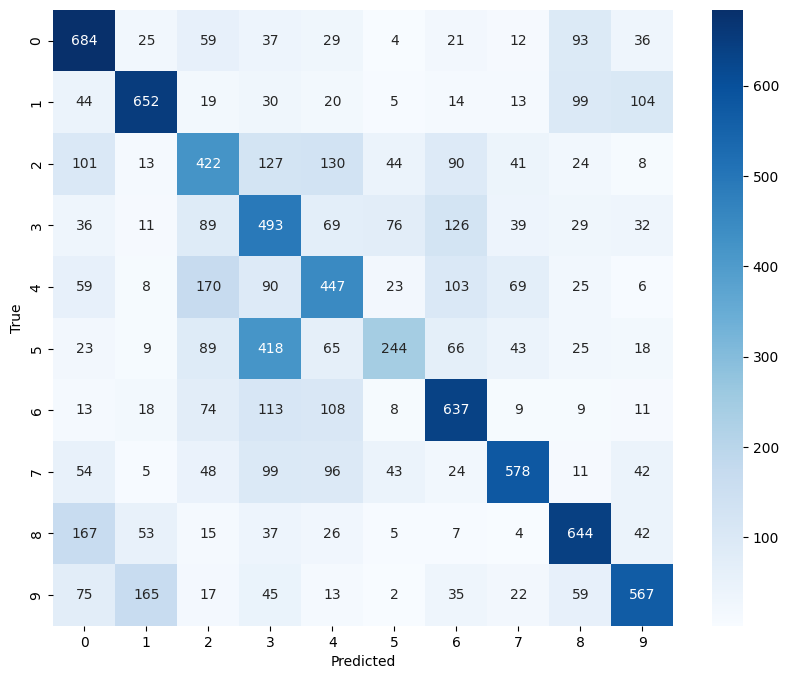

In [ ]:
#Problem 1
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import pandas as pd

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# load CIFAR-10
batch_size = 64
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

# Define MLP module
class MLP(nn.Module):
    def __init__(self, input_size=3072, hidden_sizes=[512, 256, 128], output_size=10):
        super(MLP, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(input_size, hidden_sizes[0])
        self.fc2 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
        self.fc3 = nn.Linear(hidden_sizes[1], hidden_sizes[2])
        self.fc4 = nn.Linear(hidden_sizes[2], output_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.relu(self.fc3(x))
        x = self.dropout(x)
        x = self.fc4(x)
        return x

# Initialize model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MLP().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 20
train_losses, train_accuracies, val_accuracies = [], [], []
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct, total = 0, 0
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_losses.append(running_loss / len(trainloader))
    train_accuracies.append(correct / total)

    # Validation accuracy
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    val_accuracies.append(correct / total)

    print(f"Epoch {epoch+1}/{epochs}, Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.4f}, Val Acc: {val_accuracies[-1]:.4f}")

# Plot results
plt.figure(figsize=(10,5))
plt.plot(range(1, epochs+1), train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
plt.plot(range(1, epochs+1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, epochs+1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Evaluate on test set
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Classification report
print(classification_report(all_labels, all_preds))

# Confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10,8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Save model
torch.save(model.state_dict(), 'mlp_cifar10.pth')

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt

# Load the dataset
url = "https://raw.githubusercontent.com/HamedTabkhi/Intro-to-ML/refs/heads/main/Dataset/Housing.csv"
data = pd.read_csv(url)

# Define features and target
X = data.drop('price', axis=1)
y = data['price']

# Split the data into training and validation sets (80% training, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Define numerical and categorical features
numerical_features = ['area', 'bedrooms', 'bathrooms', 'stories', 'parking']
categorical_features = ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea', 'furnishingstatus']

# Preprocessing for numerical data
numerical_transformer = StandardScaler()

# Preprocessing for categorical data
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Apply preprocessing to the data
X_train = preprocessor.fit_transform(X_train)
X_val = preprocessor.transform(X_val)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


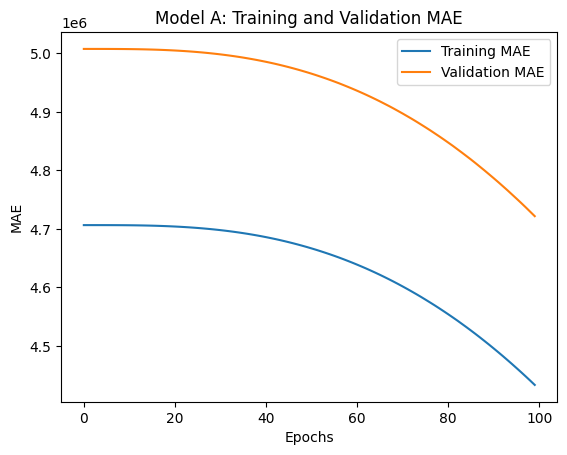

Model A - Final Validation MAE: 4721822.0
Model A - Number of Parameters: 5569


In [ ]:
# 2.a
model_a = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(64, activation='relu'),
    Dense(1)
])

# Compile the model
model_a.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
history_a = model_a.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=32, verbose=0)

# Plot training and validation results
plt.plot(history_a.history['mae'], label='Training MAE')
plt.plot(history_a.history['val_mae'], label='Validation MAE')
plt.title('Model A: Training and Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()

# Report final accuracy and model complexity
final_mae_a = history_a.history['val_mae'][-1]
print(f"Model A - Final Validation MAE: {final_mae_a}")
print(f"Model A - Number of Parameters: {model_a.count_params()}")

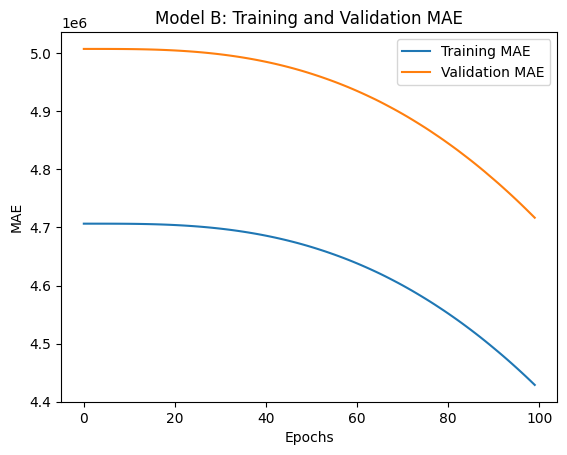

Model B - Final Validation MAE: 4716781.5
Model B - Number of Parameters: 5569


In [ ]:
# 2.b
model_b = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(64, activation='relu'),
    Dense(1)
])

# Compile the model
model_b.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
history_b = model_b.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=32, verbose=0)

# Plot training and validation results
plt.plot(history_b.history['mae'], label='Training MAE')
plt.plot(history_b.history['val_mae'], label='Validation MAE')
plt.title('Model B: Training and Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()

# Report final accuracy and model complexity
final_mae_b = history_b.history['val_mae'][-1]
print(f"Model B - Final Validation MAE: {final_mae_b}")
print(f"Model B - Number of Parameters: {model_b.count_params()}")

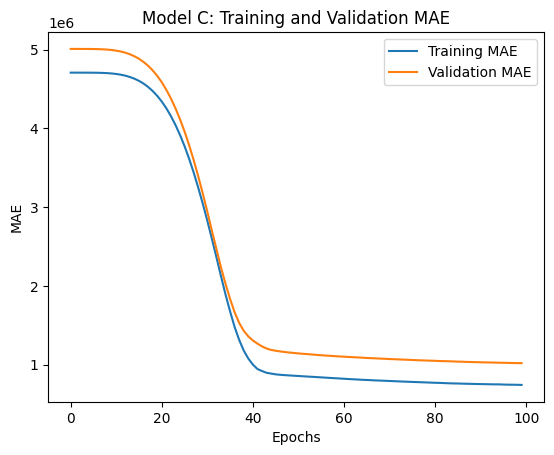

Model C - Final Validation MAE: 1020311.0625
Model C - Number of Parameters: 27521


In [ ]:
# 2.c
model_c = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1)
])

# Compile the model
model_c.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
history_c = model_c.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=32, verbose=0)

# Plot training and validation results
plt.plot(history_c.history['mae'], label='Training MAE')
plt.plot(history_c.history['val_mae'], label='Validation MAE')
plt.title('Model C: Training and Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()

# Report final accuracy and model complexity
final_mae_c = history_c.history['val_mae'][-1]
print(f"Model C - Final Validation MAE: {final_mae_c}")
print(f"Model C - Number of Parameters: {model_c.count_params()}")